In [2]:
# import kent library
import sys
sys.path.insert(0, '/data/critt/shared/Spring19/')

import kent
import importlib
importlib.reload(kent)

<module 'kent' from '/data/critt/shared/Spring19/kent.py'>

In [3]:
import pandas as pd
import numpy as np

### Define all the functions for Semantic and Orthographic Neighbors implementation

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Returns a list of semantic competitor words based on the score_limit
def semantic_competitor(comp_tuple_list, score_limit = 0.7, include_stopwords = False):
    comp_list = []
    for word,score in comp_tuple_list:
        #if word in stop_words:
            #return comp_list
        if not word.isalpha():
            return comp_list
        if score > score_limit:
            if word.isalpha() and word not in stop_words:
                comp_list.append(word)
    return comp_list


# Creates a dictionary of word to comp_list for each word in the source_words list
def find_semantic_word_dic(source_words, model):
    token_to_semantic_words_dic = dict()
    for word in set(source_words):
        try:
            # Returns a list of tuple(word, score)
            result = model.most_similar(word.lower(), negative=None, topn=100)
            # sim_score = 0.7
            comp_list = semantic_competitor(result)
        except KeyError as ex:
            comp_list = []

        token_to_semantic_words_dic[word] = comp_list
    return token_to_semantic_words_dic

def add_column(col_name, word_dic, df, ignoreCase=True):
    """
        Adds a new column to the data-frame
        Inputs -->
            col_name -> Name of the column to add
            word_dic -> Dic containing similar words for STokens
            df -> Data frame
    """
    df[col_name] = 0
    simword_count = 0
    for id in df.index:
        if ignoreCase:
            word = df.at[id,'SToken'].lower()
        else:
            word = df.at[id,'SToken']
        try: 
            simword_count = len(word_dic[word])
        except:
            simword_count = 0
        df.at[id, col_name] = simword_count

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/kent/dsahoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# read BNC word frequency dictionary 
import re

def readFreqDic(dictionary) :
    Dic = {}
    with open(dictionary,"r", encoding="utf8") as file:
        for entry in file:
            tok, num = re.findall("^(.*?)[\s]+(.*?)$", entry)[0]
            Dic[tok] = int(num)
    return (Dic)

bnc_freq_dic = readFreqDic('/data/critt/shared/Spring19/lemmaLexicon/BNC.freqLex')

### Load glove_model - Word2Vec

In [5]:
# Load Glove 6B.100d for Word2Vec
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/data/critt/shared/Spring19/w2v/glove/glove.6B.100d.word2vec.txt'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

### Load word_to_lev_dic - Dictionary with Orthographic neighbors for STokens

In [6]:
import json
# reads a file and load a json object
lev1_json = open("/users/kent/dsahoo/stoken_lev1_wordlist_new.json","r").read()
# Dic for orthographic similar words
word_to_lev_dic = json.loads(lev1_json)

In [7]:
# stoken_lev1_wordlist_new contains the dictionary of lev1 competitor set
import json
# reads a file and load a json object
lev_json = open("/users/kent/dsahoo/stoken_lev1_with_stopwords.json","r").read()
word_to_lev_dic1 = json.loads(lev_json)

### Load the stdf - Data-frame containing all the .st tables for the ENJA Study

In [8]:
# read the ENJA study data
stdf = kent.readTPDDBtables(['ENJA15/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')
source_words = set(stdf['SToken'].tolist())

In [9]:
# Dic for semantic similar words
word_to_semsim_dic = find_semantic_word_dic(source_words, glove_model)

### Salience Score and Entropy of Neighbouring Set

Salience = log frequency<br>
average salience (log frequency) of competitor words**(Salience Score)** = $1/m \sum_{s\in C} log(salience(s))$ <br>
m = salience of source word

**Entropy** = $ \sum_{s \in C} P(s)*(-log(P(s)))$<br>
C = Competitor Set

In [252]:
import numpy as np
def salience_score(token, token_dic=word_to_lev_dic1, frequency_map=bnc_freq_dic,verbose=False):
    similar_list = list()

    try:
        similar_list = token_dic[token]
    except KeyError as ex:
        return float(0)
    try:
        token_freq = frequency_map[token]
    except KeyError:
        token_freq = 20
    token_sal = np.log(token_freq)
    salience_score = 0
    summation = 0.0
    sal = 0.0
    list_length = len(similar_list)
    token_length = len(token)
    
    #word_frequencies = frequency_map[token_length]
    if similar_list:
        for word in similar_list:
            freq = frequency_map[word]
            summation += np.log(freq)
        sal = summation/token_sal
    if verbose:
        print(f"Salience score of {token} = {sal}")
    return sal

def findInDic(key, dictionary, value=None):
    try:
        value = dictionary[key]
    except KeyError:
        pass
    return value

def entropy(stoken, verbose=False):
    entropy = 0.0
    total_freq = 0
    sim_words = []
    sim_freq = []
    sim_words = findInDic(stoken, word_to_lev_dic1, list())
    if verbose:
        print(f"Similar words:\n\n{sim_words}")
    sim_freq = [ findInDic(f,bnc_freq_dic,20) for f in sim_words ] 
    if verbose:
        print(f"Similar words freq:\n\n{sim_freq}")
    if sim_freq:
        total_freq = sum(sim_freq)
        for f in sim_freq:
            p = f/total_freq
            entropy += p*(-np.log(p))
    return entropy

def similaritySetSize(stoken):
    simList = findInDic(stoken,word_to_lev_dic1,[])
    return len(simList)

def find_similar_words(word,orthoOnly=False,semanticOnly=False,semantic_dic=word_to_semsim_dic, ortho_dic=word_to_lev_dic1): 
    word = word
    orthoList = []
    semanticList = []
    print(f"Word = {word}\n")
    
    if not semanticOnly:
        orthoList = findInDic(word, ortho_dic, [])
        print(f"Orthographic Similar Words:\n\n{orthoList}\n\n")
        
    if not orthoOnly:
        semanticList = findInDic(word, semantic_dic, [])
        print(f"Semantic Similar Words:\n\n{semanticList}")
        
    return orthoList,semanticList 

In [251]:
from scipy import stats

def print_pvalue(df, indFeat, depFeat):
    stat = stats.linregress(df[indFeat], df[depFeat])
    print(f"P-value = {stat.pvalue: 2.3f}")

def similarity_plot(df, indFeat, depFeat,lengthFilter=2,logScale=True, excOutlier=True,uplengthFilter=20, hue=None):    
    # Pre process data for dependent and independent variables
    # - take out outliers (-2< and >2 SD)
    # - take out values < 0

    # independent variable
    #indFeat = "semanticSim"

    # dependent Variable
    #depFeat = "Dur"


    ###########
    # pre-process data
    data = df

    # exclude values <= 0 of independent variable
    data = data[(data[indFeat] > 0)]

    # exclude outliers of independent variable
    data = excludeOutliers(data, indFeat)

    # compute log transformation for independent Variable
    indFeatL = indFeat + "Log"
    data[indFeatL] = np.log(data[indFeat])

    #######
    # exclude outliers for dependent variable
    data = data[(data[depFeat] > 0)]
    if excOutlier: 
        data = excludeOutliers(data, depFeat)

    # compute log transformation for dependent Variable
    depFeatL = depFeat + "Log"
    data[depFeatL] = np.log(data[depFeat])

    #######
    # take log-transformation of dependent / indpendent variable
    if logScale:
        depFeat = depFeatL
    #indFeat = indFeatL

    # compute "STlen" length of SToken
    data["STlen"] = data["SToken"].apply(len)

   
    # apply length-filter
    data = data[(data.STlen > lengthFilter)]
    
    data = data[(data.STlen < uplengthFilter)]

    print(data[[ indFeat,depFeat ]].corr())
    print_pvalue(data, indFeat, depFeat)
    lmplot(data, indFeat, depFeat, hue)

In [229]:
cs19['orthoSimSize'] = cs19['SToken'].apply(similaritySetSize)
cs19['STlen'] = cs19['SToken'].apply(len)
cs19['OrthoSimEntropy'] = cs19['SToken'].apply(entropy)
cs19['OrthoSimSalience'] = cs19['SToken'].apply(salience_score)
cs19["OrthoEntropySalience"] = cs19[['OrthoSimEntropy','OrthoSimSalience']].prod(axis=1)
cs19["logDur"] = cs19['Dur'].apply(np.log)

In [230]:
cs19[['Dur','logDur','OrthoSimEntropy','OrthoSimSalience','OrthoEntropySalience']].corr()

,Dur,logDur,OrthoSimEntropy,OrthoSimSalience,OrthoEntropySalience
Dur,1.000000,0.662248,-0.146177,-0.098177,-0.099423
logDur,0.662248,1.000000,-0.385804,-0.286716,-0.295066
OrthoSimEntropy,-0.146177,-0.385804,1.000000,0.534623,0.593160
OrthoSimSalience,-0.098177,-0.286716,0.534623,1.000000,0.962046
OrthoEntropySalience,-0.099423,-0.295066,0.593160,0.962046,1.000000


### Group-by sort aggregate

In [ ]:
cs19[["SToken","OrthoSimEntropy"]].groupby('SToken').aggregate([np.max,np.mean]).sort_values(("OrthoSimEntropy","mean"), ascending=False)

In [70]:
#cs19df = kent.readTPDDBtables(['ENJA15/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')
cs19df = kent.readTPDDBtables(["PARA19/Tables/"], "*st", path="/data/critt/tprdb/KENT/")

### Merge different studies CS19, ENJA15, BML12, RUC17

In [135]:
cs19 = kent.readTPDDBtables(["PARA19/Tables/"], "*st", path="/data/critt/tprdb/KENT/")
enja = kent.readTPDDBtables(['ENJA15/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')
bml = kent.readTPDDBtables(['BML12/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')
ruc = kent.readTPDDBtables(['RUC17/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')

/data/critt/shared/Spring19/kent.py:240: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, pd.read_csv(fn, sep="\t", dtype=None)], ignore_index=True)


In [370]:
bml[['SToken','TGroup']].head(30)

,SToken,TGroup
0,Sociology,La_sociología
1,is,es
2,a,una
3,relatively,relativamente
4,new,nueva
5,academic,académica
6,discipline,disciplina
7,.,.
8,It,Surgió
9,emerged,Surgió


In [138]:
print(f"{cs19.shape} {enja.shape} {bml.shape} {ruc.shape}")

(11011, 66) (32375, 66) (25936, 66) (17509, 72)


In [136]:
merged = pd.concat([cs19, enja, bml, ruc])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [164]:
merged.shape

(86831, 75)

In [172]:
# Find the difference in the columns
(set(merged.columns.tolist())).difference(set(ruc.columns.tolist()))

{'STlen', 'logDur', 'orthoSimSalience'}

### Deep Copy of data-frame

In [72]:
newdf = cs19df.copy()

In [235]:
## Deprecated
def add_competitor_set_count(df, sim_col_name, lev_dic, add_col=False):
    if add_col:
        df[sim_col_name] = 0
        
    for id in list(df.index):
        stoken = df.at[id,'SToken'] 
        try:
            comp_list = lev_dic[stoken]
        except KeyError as ex:
            comp_list = []
        df.at[id, sim_col_name] = len(comp_list)
        
    print(f"The column {sim_col_name} updated successfully")

In [73]:
add_competitor_set_count(newdf, "orthoSimSize", word_to_lev_dic1, True)

The column orthoSimSize updated successfully


In [140]:
merged['orthoSimSalience'] = merged['SToken'].apply(lambda w: salience_score(w, word_to_lev_dic1, bnc_freq_dic,False))
merged['STlen'] = merged['SToken'].apply(len)
merged['logDur'] = merged['Dur'].apply(np.log)

In [159]:
merged[(merged.STlen >= 4) & (merged.STlen < 8) & (merged.PoS.str.match(r"^N"))][["Dur","orthoSimSalience","logDur"]].corr()

,Dur,orthoSimSalience,logDur
Dur,1.000000,-0.007906,0.388121
orthoSimSalience,-0.007906,1.000000,0.040710
logDur,0.388121,0.040710,1.000000


                  orthoSimSalience   DurLog
orthoSimSalience           1.00000  0.03403
DurLog                     0.03403  1.00000
P-value =  0.000
                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     15.64
Date:                Wed, 14 Aug 2019   Prob (F-statistic):           7.69e-05
Time:                        16:32:13   Log-Likelihood:                -31010.
No. Observations:               13494   AIC:                         6.202e+04
Df Residuals:                   13492   BIC:                         6.204e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t| 

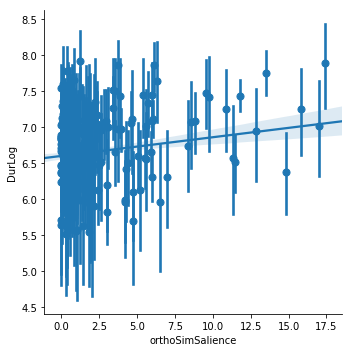

In [162]:
data = merged[(merged.STlen >= 4) & (merged.STlen < 8)]
similarity_plot(data, "orthoSimSalience", "Dur",lengthFilter=2,logScale=True, hue=None )

### Add columns to the DataFrame

In [9]:
add_column("orthoSim", word_to_lev_dic, stdf, ignoreCase=False)
add_column("semanticSim", word_to_semsim_dic, stdf)

In [101]:
import statsmodels.formula.api as smf
import statsmodels.api as sma
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def lmplot(data, indFeat, depFeat, hue=None):
    """
        Plots a Linear Regression plot
        Input:
            data -> Data frame
            depFeat -> dependent feature to be plotted on Y axis
            indFeat -> independent feature to be plotted on X axis
            hue -> category to split the plot into multiple sub-plots
    """
    form =depFeat + "~" + indFeat 
    # Add multiple variables

    if hue:
        form =depFeat + "~" + indFeat + "* " + hue
        
    lmf = smf.ols(formula=form, data=data).fit()

    print(lmf.summary())

    sns.lmplot(y=depFeat, x=indFeat, hue=hue, x_estimator=np.mean, data=data);

    plt.show()

# exclude outliers in dataframe df 
def excludeOutliers(df, col) :
    
    mean = np.mean(np.array(df[col]), axis=0)
    sd = np.std(np.array(df[col]), axis=0)
    
    return(df[(df[col] > mean - 2 * sd) & (df[col] < mean + 2 * sd)])

In [49]:
col_list = "Text SToken orthoSim semanticSim".split()
stdf[[col for col in col_list]].head(10)

,Text,SToken,orthoSim,semanticSim
0,3,Spielberg,0,0
1,3,shows,12,16
2,3,Beijing,0,0
3,3,red,55,8
4,3,card,31,1
5,3,over,0,12
6,3,Darfur,0,0
7,3,In,0,1
8,3,a,0,30
9,3,gesture,2,1


             semanticSim       Dur
semanticSim     1.000000  0.008411
Dur             0.008411  1.000000
P-value =  0.439
                            OLS Regression Results                            
Dep. Variable:                    Dur   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5994
Date:                Wed, 07 Aug 2019   Prob (F-statistic):              0.439
Time:                        15:10:32   Log-Likelihood:                -86369.
No. Observations:                8474   AIC:                         1.727e+05
Df Residuals:                    8472   BIC:                         1.728e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------

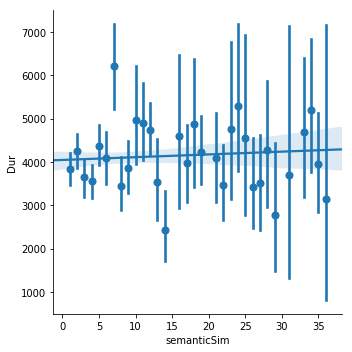

In [482]:
similarity_plot(stdf, "semanticSim", "Dur",lengthFilter=2,logScale=False)

          orthoSim    DurLog
orthoSim  1.000000 -0.023556
DurLog   -0.023556  1.000000
P-value =  0.052
                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.785
Date:                Wed, 07 Aug 2019   Prob (F-statistic):             0.0518
Time:                        15:05:32   Log-Likelihood:                -18042.
No. Observations:                6819   AIC:                         3.609e+04
Df Residuals:                    6817   BIC:                         3.610e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


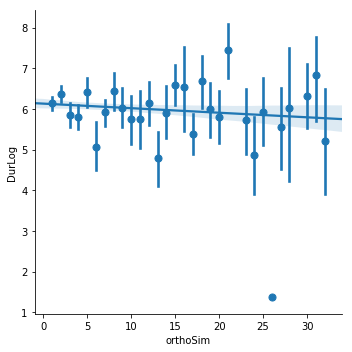

In [478]:
similarity_plot(stdf, "orthoSim", "Dur",lengthFilter=2,logScale=True)

### Creates a pivot table for ST dataframe

In [369]:
pivot = stdf.pivot_table(index=["Text","Id","SToken"],values=['HTra','Dur','semanticSim','orthoSim'],aggfunc={'HTra':[np.max, np.mean,np.count_nonzero],'semanticSim':np.count_nonzero,'orthoSim':[np.min,np.max,np.count_nonzero],'Dur':[np.min,np.max,np.mean]})
#np.max

In [166]:
pivot.loc[1,:].head()

Dur                       HTra                        \
                 amax amin          mean    amax count_nonzero    mean   
Id SToken                                                                
1  Killer    115456.0  0.0   9034.923077  3.0328          39.0  3.0328   
2  nurse     138638.0  0.0  10668.820513  3.3776          39.0  3.3776   
3  receives   92836.0  0.0   4678.717949  3.5791          39.0  3.5791   
4  four       16047.0  0.0   1853.282051  3.5210          39.0  3.5210   
5  life           0.0  0.0      0.000000  1.4596          39.0  1.4596   

            orthoSim        semanticSim  
                amax amin count_nonzero  
Id SToken                                
1  Killer         12   12             0  
2  nurse           7    7            39  
3  receives        5    5            39  
4  four           17   17            39  
5  life           18   18            39

Multi-indexes can be accessed using the following methods
- Using .loc
- Using slice()
- multi-index indices can be converted to tuples by using df.index.tolist()
- multi-index columns can also be read as tuples. For e.g. ('HTra','mean')

Examples
- pivot.loc[(slice(1,2), slice(1,5)),((slice('semanticSim'),slice('amin')))]
- pivot.loc[[i for i in multi_index if i[0]==3]][['HTra','Dur']]
- pivot.loc[2,[('HTra','amax'),('Dur','amax')]]

In [ ]:
# multi-indexes are represented as tuples
multi_index =  pivot.index.tolist()
col_multi_index = list(pivot.columns.values)
#pivot.loc[[i for i in multi_index if i[0]==3]][['HTra','Dur']]
pivot.loc[[i for i in multi_index if i[0]==3]][[j for j in col_multi_index if j[1] == 'mean']]

In [ ]:

pivot.loc[2,[('HTra','amax'),('Dur','amax')]]

In [ ]:
# Heirarchical column index using IndexSlice
idx = pd.IndexSlice
#pivot.loc[1,idx[:'semanticSim','amax':'count_nonzero']]
pivot.loc[idx[:3,2:5],idx[:'semanticSim','amax':'count_nonzero']]

In [ ]:
# Use slice() for multi-index on both rows and columns
pivot.loc[(slice(1,2), slice(1,5)),((slice('semanticSim'),slice('amin')))]

In [ ]:
# select heirarchical columns as tuples.

pivot.loc[(slice(1,2), slice(1,5)),:][[('HTra','amax'),('Dur','amax'),('semanticSim','count_nonzero')]]

### Sorting in Pivot Table

In [ ]:
# Sort multi-index by level
pivot.sort_index(level='Id',ascending=False)

In [375]:
aa = pivot.loc[:][[('HTra','mean'),('orthoSim','count_nonzero'),('semanticSim','count_nonzero')]]

In [388]:
# Sort by value
aa.sort_values(('HTra','mean'),ascending=False).head()

HTra      orthoSim   semanticSim
                        mean count_nonzero count_nonzero
Text Id  SToken                                         
2    115 those        5.2479             0            38
1    102 the          5.2341             0            39
     103 awareness    5.2341             0             0
4    69  contributed  5.2095            37             0
     68  have         5.2095             0            37

In [356]:
a = np.random.randint(1,100,15)
b = np.random.randint(1,100,15)
c = np.random.randint(1,100,15)
dff = pd.DataFrame(index=[i for i in range(15)], columns=["A","B","C"], data={"A":a,"B":b,"C":c}, dtype=str)

### RUC17 Study

In [390]:
# read the ENJA study data
rucdf = kent.readTPDDBtables(['RUC17/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')
ruc_source_words = set(rucdf['SToken'].tolist())

In [391]:
add_column("orthoSim", word_to_lev_dic, rucdf, ignoreCase=False)
add_column("semanticSim", word_to_semsim_dic, rucdf)

             semanticSim    DurLog
semanticSim     1.000000  0.048044
DurLog          0.048044  1.000000
P-value =  0.002
                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.735
Date:                Mon, 05 Aug 2019   Prob (F-statistic):            0.00182
Time:                        15:36:36   Log-Likelihood:                -7647.8
No. Observations:                4210   AIC:                         1.530e+04
Df Residuals:                    4208   BIC:                         1.531e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------

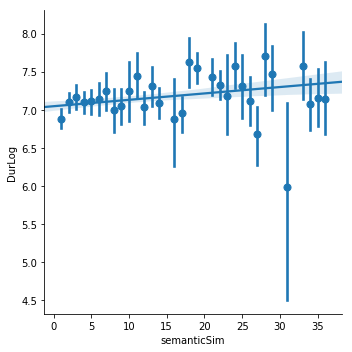

In [392]:
similarity_plot(rucdf, "semanticSim", "Dur")

             semanticSim     HTra
semanticSim      1.00000  0.08633
HTra             0.08633  1.00000
P-value =  0.000
                            OLS Regression Results                            
Dep. Variable:                   HTra   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     76.15
Date:                Wed, 07 Aug 2019   Prob (F-statistic):           3.05e-18
Time:                        15:41:18   Log-Likelihood:                -13878.
No. Observations:               10143   AIC:                         2.776e+04
Df Residuals:                   10141   BIC:                         2.777e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------

/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


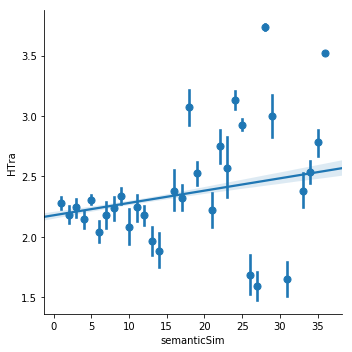

In [488]:
similarity_plot(rucdf, "semanticSim", "HTra",lengthFilter=2,logScale=False)

          orthoSim    DurLog
orthoSim  1.000000 -0.045996
DurLog   -0.045996  1.000000
P-value =  0.008
                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.026
Date:                Mon, 05 Aug 2019   Prob (F-statistic):            0.00807
Time:                        15:37:06   Log-Likelihood:                -6063.5
No. Observations:                3316   AIC:                         1.213e+04
Df Residuals:                    3314   BIC:                         1.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

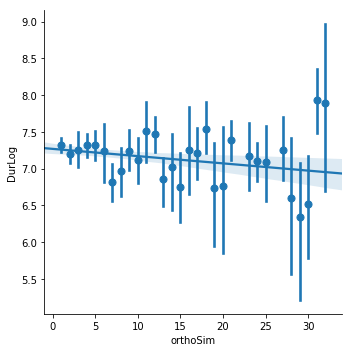

In [393]:
similarity_plot(rucdf, "orthoSim", "Dur")

### BML12 Study

In [394]:
# read the ENJA study data
bmldf = kent.readTPDDBtables(['BML12/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')
bml_source_words = set(bmldf['SToken'].tolist())

In [405]:
add_column("orthoSim", word_to_lev_dic, bmldf, ignoreCase=False)
add_column("semanticSim", word_to_semsim_dic, bmldf)

             semanticSim    DurLog
semanticSim     1.000000  0.062752
DurLog          0.062752  1.000000
P-value =  0.000
                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     22.18
Date:                Mon, 05 Aug 2019   Prob (F-statistic):           2.54e-06
Time:                        16:12:15   Log-Likelihood:                -10069.
No. Observations:                5613   AIC:                         2.014e+04
Df Residuals:                    5611   BIC:                         2.016e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------

/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


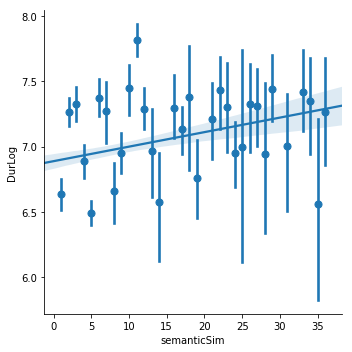

In [396]:
similarity_plot(bmldf, "semanticSim", "Dur")

          orthoSim    DurLog
orthoSim  1.000000 -0.039806
DurLog   -0.039806  1.000000
P-value =  0.024
                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.102
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0240
Time:                        16:55:35   Log-Likelihood:                -5409.1
No. Observations:                3217   AIC:                         1.082e+04
Df Residuals:                    3215   BIC:                         1.083e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

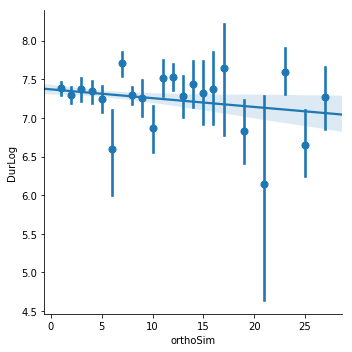

In [406]:
similarity_plot(bmldf, "orthoSim", "Dur",lengthFilter=4)

             semanticSim   DurLog
semanticSim      1.00000  0.07666
DurLog           0.07666  1.00000
P-value =  0.000
                            OLS Regression Results                            
Dep. Variable:                 DurLog   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     24.17
Date:                Wed, 07 Aug 2019   Prob (F-statistic):           9.15e-07
Time:                        16:15:51   Log-Likelihood:                -7444.5
No. Observations:                4091   AIC:                         1.489e+04
Df Residuals:                    4089   BIC:                         1.491e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------

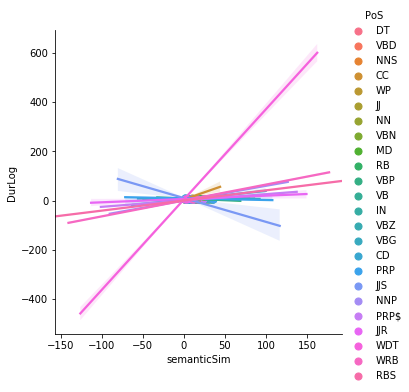

In [543]:
similarity_plot(bmldf, "semanticSim", "Dur",lengthFilter=2,logScale=True, uplengthFilter=8)

### Word2Vec Implementation

In [ ]:
# for each word in the semantic similarity list
    # find frequency from bmc, take its log, multiply it with similarity score.
# Sum of all such score.


# sum of all similarity scores of the similar set

# 

#precision and recall



In [341]:
import nltk
import numpy as np

# Returns a list of semantic competitor words based on the score_limit
def semantic_sim_set(comp_tuple_list, score_limit = 0.7, include_stopwords = False):
    comp_list = []
    
    comp_list = [(word,score) for word,score in comp_tuple_list if word.isalpha() and score >= score_limit ]
    return comp_list


# Creates a dictionary of word to comp_list for each word in the source_words list
def semantic_similar_words_dic(stoken_list, model, topn=100, score_limit=0.7):
    token_to_semantic_words_dic = dict()
    for stoken in set(stoken_list):
        token_to_semantic_words_dic[stoken] = get_semantic_similar_word_list(stoken, model)
        
    return token_to_semantic_words_dic

def get_semantic_similar_word_list(stoken, model=glove_model, topn=100, score_limit=0.7):
    """
    This function gets the semantic similar words of the input stoken
    Input
        stoken - source token from tpr db
        model - word2vec model
        topn - maximum number of words to find from the model ( default = 100)
        score_limit - threshold similarity score(default = 0.7)
    """
    # Throws KeyError if word not in vocabulary
    try:
        result = model.most_similar(stoken.lower(), negative=None, topn=topn)
    except KeyError:
        result = []
    comp_list = semantic_sim_set(result,score_limit=score_limit)
    
    return comp_list

## To be used by function summation_freq_simscore()
def eval_freq_score(word, score, log_scale, min_freq=20, freq_dic=bnc_freq_dic):
    freq = bnc_freq_dic.get(word)
    if not freq:
        freq = min_freq
    if log_scale:
        return np.log2(freq)*score
    else:
        return freq*score
    
# Calculates entropy given an input of list containing frequency
def calc_entropy(freq_list):
    entropy = 0.0
    if freq_list: 
        total_freq = sum(freq_list)
        prob_list = [f/total_freq for f in freq_list]
        entropy = sum([-p*np.log(p) for p in prob_list])
    return entropy

## Below functions can be applied to a column using .apply() function
    
def summation_freq_simscore(stoken, freq_dic=bnc_freq_dic, model=glove_model, min_freq=20,log_scale=True):
    score = 0.0
    sim_list = get_semantic_similar_word_list(stoken, model)
    if not sim_list:
        return score
    #summ_list = [score*freq_dic.get(word) if freq_dic.get(word)  else min_freq*score for word,score in sim_list]
    summ_list = [eval_freq_score(word,score,log_scale) for word,score in sim_list]
        
    return sum(summ_list)

def sum_sim_scores(stoken, model=glove_model):
    score_sum = 0.0
    sim_list = get_semantic_similar_word_list(stoken, model)
    if sim_list:
        score_list = [score for word,score in sim_list]
        score_sum = sum(score_list)
    return(score_sum)


def entropy_semantic_sim(stoken, model=glove_model, freq_dic=bnc_freq_dic, min_freq=20):
    entropy = 0.0
    sim_list = get_semantic_similar_word_list(stoken, model)
    if sim_list:
        freq_list = [ freq_dic.get(word) if freq_dic.get(word) else min_freq for word,freq in sim_list ]
        entropy = calc_entropy(freq_list) 
    
    return entropy
    
def entropy_ortho_sim(stoken, lev_dic=word_to_lev_dic1, freq_dic=bnc_freq_dic, min_freq=20, verbose=False):
    """
    Calculates the entropy of the orthographic similar words(SS) of an input stoken taking into consideration
    the frequency of the SS in the freq_dic
    Input
        stoken - source token from TPR db
        lev_dic - dictionary with levenshtein's distance=1
        freq_dic - dictionary containing words with its frequency
        min_freq - min freq of the word (default=20)
    """
    entropy = 0.0
    
    sim_words = lev_dic.get(stoken)
    if sim_words: 
        if verbose:
            print(f"Similar words:\n\n{sim_words}")
        freq_list = [ freq_dic.get(word) if freq_dic.get(word) else min_freq for word in sim_words ]
        if verbose:
            print(f"Similar words freq:\n\n{freq_list}")
        entropy = calc_entropy(freq_list) 
    return entropy
    

In [327]:
token = "Government"
print([word for word,score in get_semantic_similar_word_list(token)])
print(f"SemanticSim Length: {len(get_semantic_similar_word_list(token))}")
print(f"Entropy: {entropy_semantic_sim(token)}")
print(f"Sum Sim Scores: {sum_sim_scores(token)}")
print(f"Summation Freq*Score: {summation_freq_simscore(token)}")
print(f"Summation log_Freq*Score: {summation_freq_simscore(token,log_scale=False)}")

['administration', 'governments', 'officials', 'authorities', 'opposition', 'saying', 'official', 'country', 'promised', 'military', 'backed', 'ministry', 'office', 'support', 'federal', 'state', 'security', 'foreign', 'that', 'would', 'public', 'demanded']
SemanticSim Length: 22
Entropy: 1.3257510608034644
Sum Sim Scores: 16.002248167991638
Summation Freq*Score: 221.34830182160542
Summation log_Freq*Score: 1175768.391202569


### stokens_sim_similar_words_dic 

- It contains a dictionary of semantically similar words for each source tokens
- Hyper parameters: topn=100 score_limit=0.7

In [272]:
stokens_sim_similar_words_dic = semantic_similar_words_dic(source_words,glove_model)

In [175]:
# Creates a frequency dictionary with key as the lenght of the string and value as a list of key:value containing word:frequency
# It eliminates the numerical, alphanumerical and special characters containing strings
import re
def create_freq_dic(dic):
    new_dic = dict()
    new_dic.setdefault(1,dict())
    for key in dic.keys():
        l = len(key)
        #if l> 20:
            #print(str(key) + "   " + str(dic[key]))
        #new_dic.setdefault(l,dict())
        pattern = r"[a-zA-Z]{"+str(l)+"}"
        is_alpha = re.fullmatch(pattern, key)
        if l == 1: 
            continue
        else:
            if is_alpha:
                try:
                    new_dic[l][key] = dic[key]
                except KeyError as er:
                    new_dic.setdefault(l,dict())
                    new_dic[l][key] = dic[key]
    return new_dic  

In [ ]:
%%time
length_

### Analysis of BNC freq dictionary

In [345]:
cs19.head()

,Id,STseg,Study,Session,SL,TL,Task,Text,Part,SToken,...,HSeg,HCross,STlen,OrthoSimEntropy,OrthoSimSalience,OrthoEntropySalience,logDur,orthoSimSize,orthoSimSize_N,OrthoSim
0,1,1,PARA19,P01_C1,en,en,C,1,P01,Killer,...,1.2389,1.8920,6,0.913315,18.341656,16.751713,8.339979,12,12,0.913315
1,2,1,PARA19,P01_C1,en,en,C,1,P01,nurse,...,0.7793,1.8230,5,1.201237,4.639932,5.573658,6.997596,7,7,1.201237
2,3,1,PARA19,P01_C1,en,en,C,1,P01,receives,...,1.1401,1.8230,8,0.938670,4.857581,4.559664,7.440147,5,5,0.938670
3,4,1,PARA19,P01_C1,en,en,C,1,P01,four,...,0.7793,1.4885,4,0.764883,11.086801,8.480101,7.393263,17,17,0.764883
4,5,1,PARA19,P01_C1,en,en,C,1,P01,life,...,0.8905,0.8905,4,1.131293,10.436465,11.806704,6.756932,18,18,1.131293


In [256]:
num_words = 0
max_freq = 0
min_freq = 0
max_freq_word = ''
for key in len_words_dic.keys():
    len_map = len_words_dic[key]
    keys = len_map.keys()
    num_words += len(keys)
    for k in keys:
        #max_freq = max(max_freq, len_map[k])
        if len_map[k] > max_freq:
            max_freq_word = k
            max_freq = len_map[k]
        min_freq = min(min_freq, len_map[k])
        
print(f"Total words: {num_words}\tMax freq: {max_freq}\t Min freq: {min_freq}")
print(f"Max freq word: {max_freq_word}")

Total words: 333261	Max freq: 6054522	 Min freq: 0
Max freq word: the


In [350]:
sorted_bnc_freq_dic = sorted(bnc_freq_dic.items(), key=lambda x: x[1], reverse=True)

In [357]:
n=5000
i=0
top_500_freq = []
for item in sorted_bnc_freq_dic:
    if i < n:
        if item[0].isalpha():
            top_500_freq.append(item)
            i+=1

In [362]:
import json

In [367]:
top_5000_words_dic = {a[0]:a[1] for a in top_500_freq}
top_5000_words_json = json.dumps(top_5000_words_dic)
f = open('top_5000_freq_eng_words.txt','w')
f.write(top_5000_words_json)
f.close()